In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(5,3)
import scipy.stats as stats

$$C_i|\lambda \sim Poi(\lambda)$$
$$\lambda|\tau, \alpha = \left\{
\begin{matrix}
\lambda_1 & \mbox{if } t<\tau\\
\lambda_2 & \mbox{if } t\geq\tau\\
\end{matrix}
\right. $$ 

\begin{align}
&\lambda_1|\alpha \sim \text{Exp}( \alpha ) \\\
&\lambda_2|\alpha \sim \text{Exp}( \alpha )
\end{align}
$$ \tau \sim \text{DiscreteUniform(1,70) }$$

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 


In [3]:
count_data = np.loadtxt("./data/txtdata.csv")
n_count_data = len(count_data)

np.random.seed(0)
# 모델을 구성
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [4]:
### 모델에서 랜덤샘플을 추출
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

<ipython-input-4-ed758cf1908a>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, tune=5000,step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 54 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [5]:
trace

<MultiTrace: 4 chains, 10000 iterations, 5 variables>

In [8]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [9]:
trace.varnames

['lambda_1_log__', 'lambda_2_log__', 'tau', 'lambda_1', 'lambda_2']

#### 1. `lambda_1_samples` 과 `lambda_2_samples`을 사용하여 $\lambda_1$과 $\lambda_2$의 posterior mean을 계산하여라 

In [10]:
lambda_1_samples.mean()

17.751508980640267

In [11]:
lambda_2_samples.mean()

22.71299443299818

#### 2. 메세지의 개수는 몇 % 증가한 것으로 기대되는가?

`hint:`  `lambda_2_samples/lambda_1_samples`

In [12]:
np.mean(lambda_2_samples/lambda_1_samples)
# gamma = lambda2/lambda1 새로운 parameter에 대한 posterior mean

1.2811408632206764

#### 3. 사용자의 메세지 사용 패턴이 변화한 것이 day 45 이전이라는 것을 알고 있다고 하자.  그렇다면  $\lambda_1$과 $\lambda_2$의 posterior mean은 무엇인가?

In [13]:
lambda_1_samples[tau_samples<45].mean()

17.74785072831785

In [14]:
lambda_2_samples[tau_samples<45].mean()

22.60802011257718

### 만일 문자메세지 사용 패턴의 변화가 두 시점에 걸쳐서 일어난다면? 


$$C_i|\lambda \sim Poi(\lambda)$$
$$\lambda|\tau_1, \tau_2, \alpha = \left\{
\begin{matrix}
\lambda_1 & \mbox{if } t<\tau_1\\
\lambda_2 & \mbox{if } \tau_1 \leq t <\tau_2\\
\lambda_3 & \mbox{if } t\geq\tau_2\\
\end{matrix}
\right. $$ 

\begin{align}
&\lambda_1|\alpha \sim \text{Exp}( \alpha ) \\\
&\lambda_2|\alpha \sim \text{Exp}( \alpha )\\\
&\lambda_3|\alpha \sim \text{Exp}( \alpha )
\end{align}
$$ \tau_1 \sim \text{DiscreteUniform(1,72) }$$
$$ \tau_2 \sim \text{DiscreteUniform(} \tau_1,73) $$

$$\frac{1}{N}\sum_{i=0}^N \;C_i = \frac{1}{\alpha}$$ 


#### 4. 아래 코드의 빈칸을 채워 모델링을 완성하시오. 

In [15]:
np.random.seed(0)
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  

    ## 빈칸채우기 시작 
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)
    tau_1 = pm.DiscreteUniform("tau_1", lower=1, upper=n_count_data - 2)
    tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data - 1)

    ## 빈칸채우기 끝
    
    idx = np.arange(n_count_data) # Index -- t
    lambda_ = pm.math.switch(tau_2 > idx, pm.math.switch(tau_1 > idx, lambda_1, lambda_2), lambda_3)
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [16]:
### 모델에서 랜덤샘플을 추출
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=500,step=step)

<ipython-input-16-da1c7d7a9557>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=500,step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_2]
>Metropolis: [tau_1]
>Metropolis: [lambda_3]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 44 seconds.
C:\Users\JangSeongHyun\anaconda3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The estimated number of effective samples is smaller than 200 for some parameters.


#### 5. 아래 코드의 빈칸을 채워 추출된 샘플을 저장하시오.

In [17]:
trace.varnames

['lambda_1_log__',
 'lambda_2_log__',
 'lambda_3_log__',
 'tau_1',
 'tau_2',
 'lambda_1',
 'lambda_2',
 'lambda_3']

In [18]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
lambda_3_samples = trace['lambda_3']
tau_1_samples = trace['tau_1']
tau_2_samples = trace['tau_2']

#### 6. $\lambda_1, \lambda_2, \lambda_3$의 posterior mean은 어떻게 다른가?

In [19]:
lambda_1_samples.mean(),lambda_2_samples.mean(),lambda_3_samples.mean()

(17.74481528970385, 58.285776844344745, 20.067080824881735)

#### 7. $\tau_1$, $\tau_2$의 posterior mean은 어떻게 다른가? 

In [20]:
tau_1_samples.mean(),tau_2_samples.mean()

(45.0, 47.0345)

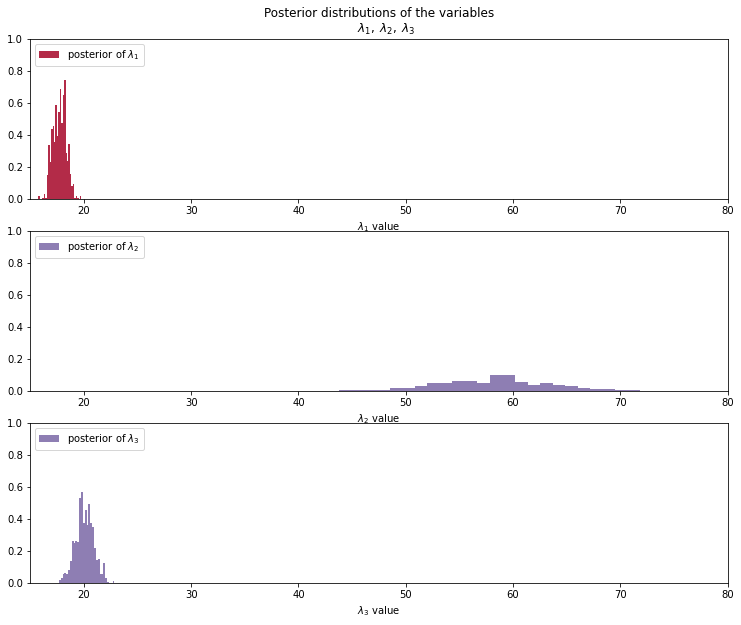

In [21]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\lambda_3$""")
plt.xlim([15, 80])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 80])
plt.xlabel("$\lambda_2$ value")

ax = plt.subplot(313)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 80])
plt.xlabel("$\lambda_3$ value")
plt.show()

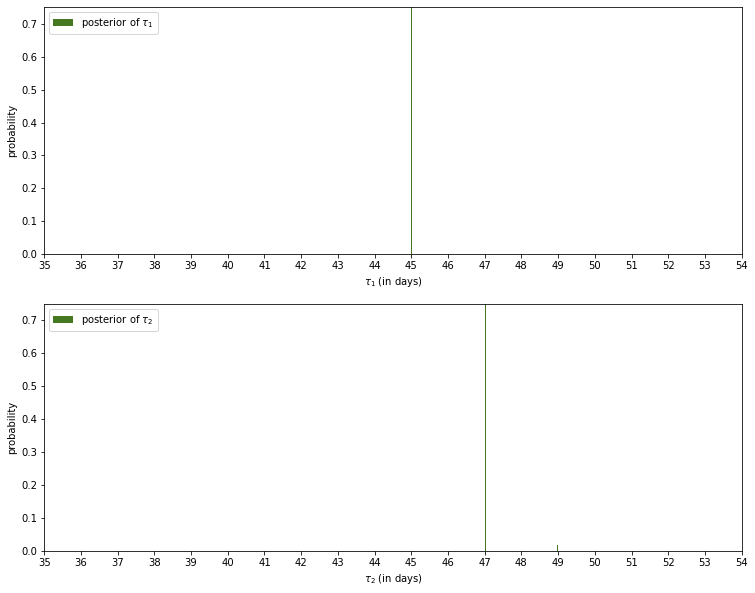

In [22]:

plt.subplot(211)
w = 1.0 / tau_1_samples.shape[0] * np.ones_like(tau_1_samples)
plt.hist(tau_1_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau_1$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau_1$ (in days)")
plt.ylabel("probability");


plt.subplot(212)
w = 1.0 / tau_2_samples.shape[0] * np.ones_like(tau_2_samples)
plt.hist(tau_2_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau_2$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau_2$ (in days)")
plt.ylabel("probability");


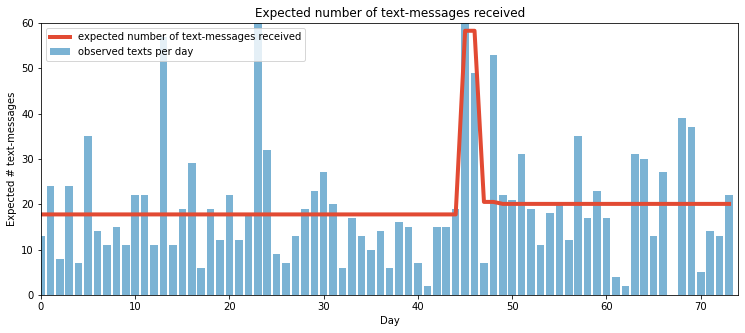

In [23]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_1_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix1 = day < tau_1_samples
    ix2 = np.logical_and(day < tau_2_samples, day >= tau_1_samples)
    ix3 = day >= tau_2_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix1].sum()
                                   + lambda_2_samples[ix2].sum()
                                   + lambda_3_samples[ix3].sum()  ) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");